# Visual Odometry
This notebook focuses on implementing visual odometry using stereo vision depth estimation and multiple-view geometry techniques to track a vehicle's position and orientation within a sequence of images from the KITTI dataset.

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from typing import Iterator, Optional, Literal

from dotenv import load_dotenv

_ = load_dotenv()

## Dataset Handler

Create a `DatasetHandler` class to efficiently load left and right images using a generator, enabling sequential access to image pairs. Additionally, it should load ground truth poses and calibration matrices from the KITTI dataset, ensuring proper alignment between image data and real-world transformations for visual odometry applications.

In [3]:
class DatasetHandler(object):
    def __init__(self) -> None:
        self.l_dir: Path = Path(os.getenv('img_l_dir'))
        self.r_dir: Path = Path(os.getenv('img_r_dir'))
        self.l_files: list = sorted(self.l_dir.glob('*.png'), key=lambda f: int(f.stem))
        self.r_files: list = sorted(self.r_dir.glob('*.png'), key=lambda f: int(f.stem))
        self.frame_num: int = len(self.l_files)

        # Load ground truth poses
        poses = pd.read_csv(os.getenv('poses_file'), delimiter=' ', header=None)
        self.gt: np.ndarray = poses.values.reshape((-1, 3, 4))

        # Load camera calibration matrices
        calib = pd.read_csv(os.getenv('calib_file'), delimiter=' ', header=None, index_col=0)
        self.K0, self.K1, self.Tr = [
            np.array(calib.loc[x, :]).reshape((3, 4)) for x in ('P0:', 'P1:', 'Tr:')
        ]

        self._reset_frame()

    def next_frame(self) -> tuple:
        self.l_prev, self.r_prev, self.l_curr = (
            self.l_curr,
            next(self.r_imgs),
            next(self.l_imgs)
        )
        return self.l_prev, self.r_prev, self.l_curr

    @property
    def imsize(self) -> tuple[int, int]:
        return self.ih, self.iw    

    def _reset_frame(self) -> None:
        self.l_imgs: Iterator[cv2.Mat] = (cv2.imread(str(f), 0) for f in self.l_files)
        self.r_imgs: Iterator[cv2.Mat] = (cv2.imread(str(f), 0) for f in self.r_files)
        
        self.l_curr = next(self.l_imgs)
        self.ih, self.iw = self.l_curr.shape

The `WLidarHandler` class extends the DatasetHandler to support loading point cloud data from lidar scans. The class includes a function to load binary point cloud files, typically stored in KITTI’s Velodyne format, and integrates them with the existing image and pose data. Additionally, it allows retrieval of synchronized lidar and camera data, ensuring proper alignment for visual odometry and sensor fusion applications. This extension enables more accurate motion estimation by incorporating depth-rich lidar information.

In [4]:
class WLidarHandler(DatasetHandler):
    def __init__(self) -> None:
        super().__init__()
        self.pcd: Path = Path(os.getenv('lidar_dir'))
        self.pcf: list = sorted(self.pcd.glob('*.bin'), key=lambda f: int(f.stem))
        self.pcl: Iterator[np.ndarray] = (
            np.fromfile(f, dtype=np.float32, count=-1) for f in self.pcf
        )

    def next_frame(self) -> None:
        super().next_frame()
        self.lidar: np.ndarray = next(self.pcl)
        return self.l_prev, self.r_prev, self.l_curr, self.lidar

Total frame number: 1106.


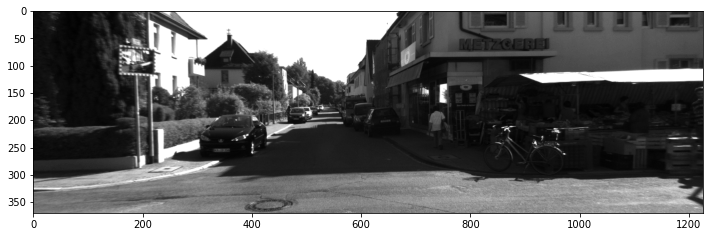

In [5]:
h = DatasetHandler()
l_img, *_ = h.next_frame()

print(f'Total frame number: {h.frame_num}.')

plt.figure(figsize=(12, 6))
plt.imshow(l_img, cmap='gray')
plt.show()

With the `DatasetHandler`, we can continuously load image and point cloud data from files. The `next_frame()` method returns the **left_image** and **right_image** at time `t` for stereo vision, along with the **left_image** at time `t+1` for transformation estimation.  

## Visual Odometry
After obtaining 3D points $\mathbf P_c$ in camera coordinate by stereo depth estimation, we need to estimate the camera motion $(R, t)$ by aligning these 3D points with their corresponding 2D observations $\mathbf p=(u'.v')$ in the second image. The transformation from the initial camera coordinate system to the new camera coordinate system is:

$$
\mathbf P'_c=R\mathbf P_c+t
$$

In the second image, the projected 2D points are:

$$
\begin{bmatrix}u'\\ v'\\1 \end{bmatrix} \sim \mathbf K(R\mathbf P_c+t)
$$

This equation forms the basis of the PnP problem: given 3D-2D correspondences $(\mathbf P_c, \mathbf p')$, and estimate $R$ and $t$.

The `cv2.solvePnPRansac` function solves this problem by minimizing the **reprojection error**, which measures how well the projected 3D points align with the observed 2D keypoints:

$$
\sum_i ||\mathbf p'_i-\pi (R\mathbf P_{ci}+t)||^2
$$

where $\pi(\cdot)$ is the projection function. Besides, **RANSAC (Random Sample Consensus)** is applied to improve robustness by iteratively selecting random subsets of correspondences, solving for $R,t$, and discarding outliers.

In [6]:
class VisualOdometry(object):
    def __init__(
        self, 
        P0: np.ndarray,
        P1: np.ndarray,
        Tr: np.ndarray,
        isize: tuple[int, int],
        lidar: bool = False,
        stereo_matcher: Optional[Literal['bm', 'sgbm']] = None,
        detector: Literal['orb', 'sift'] = 'orb',
        matching: Literal['bf', 'flann'] = 'bf',
        matching_threshold: Optional[float] = None
    ) -> None:
        self.P0, self.P1, self.Tr = P0, P1, Tr
        self.K0, _, self.t0, *_ = cv2.decomposeProjectionMatrix(self.P0)
        self.K1, _, self.t1, *_ = cv2.decomposeProjectionMatrix(self.P1)
        self.f = self.K0[0, 0]
        self.b = self.t1[0] - self.t0[0]
        self.ih, self.iw = isize
        self.cx, self.cy = self.K0[0, 2], self.K0[1, 2]
        self.fx, self.fy = self.K0[0, 0], self.K0[1, 1]

        # Stereo matcher
        self._lidar: bool = lidar
        self._stereo_matcher: Optional[cv2.StereoBM | cv2.StereoSGBM] = None
        if stereo_matcher == 'sgbm':
            self._stereo_matcher = cv2.StereoSGBM.create(
                numDisparities=96,
                minDisparity=0,
                blockSize=11,
                P1 = 8 * 3 * 6 ** 2, 
                P2 = 32 * 3 * 6 ** 2,
                mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
            )
        elif stereo_matcher == 'bm':
            self._stereo_matcher = cv2.StereoBM.create(numDisparities=96, blockSize=11)

        # Feature detector and matcher
        self._feature_detector: cv2.ORB | cv2.SIFT = {
            'orb': cv2.ORB.create, 
            'sift': cv2.SIFT.create
        }[detector]()
        
        if matching == 'bf':
            self._feature_matcher = cv2.BFMatcher.create(
                cv2.NORM_L2 if detector == 'sift' else cv2.NORM_HAMMING2,
                crossCheck=False
            )
        else:
            self._feature_matcher = cv2.FlannBasedMatcher(
                dict(algorithm=1, trees=5), 
                dict(checks=50)
            )
        self.threshold: Optional[float] = matching_threshold

        # Trajectory
        self.T: np.ndarray = np.eye(4)
        self.traj: np.ndarray = np.zeros((1, 3, 4))
        self.traj[0] = self.T[:3, :]

    def update(
        self,
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        image_l1: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> None:
        depth: Optional[np.ndarray] = None
        if self._stereo_matcher:
            depth = self._depth_estimate(image_l0, image_r0, point_clould)

        kp0, des0 = self._feature_detector.detectAndCompute(image_l0, None)
        kp1, des1 = self._feature_detector.detectAndCompute(image_l1, None)

        matches = self._features_matching(des0, des1)
        R, t = self._motion_estimate(kp0, kp1, matches, depth)

        T_hom: np.ndarray = np.eye(4)
        T_hom[:3, :3], T_hom[:3, 3] = R, t.T
        self.T = self.T @ np.linalg.inv(T_hom)
        self.traj = np.vstack((self.traj, self.T[:3, :][np.newaxis]))
        
    def _depth_estimate(
        self, 
        image_l0: np.ndarray,
        image_r0: np.ndarray,
        point_clould: Optional[np.ndarray] = None
    ) -> np.ndarray:
        disp = self._stereo_matcher.compute(image_l0, image_r0).astype(np.float32) / 16
        disp = np.maximum(disp, 0.1)
        
        depth = (self.f * self.b) / disp
        if not point_clould is None or not self._lidar:
            return depth
        
        # Lidar depth correction
        pcl = point_clould[point_clould[:, 0] > 0]
        cam = self.Tr @ np.c_[pcl[:, :3], np.ones(len(pcl))].T
        cam = cam[:, cam[2] > 0]

        pixel_coord = (self.P0 @ cam / cam[2]).T[:, :2].round().astype(int)
        valid_pixels = (0 <= pixel_coord[:, 0]) & (pixel_coord[:, 0] < self.iw) & \
                       (0 <= pixel_coord[:, 1]) & (pixel_coord[:, 1] < self.ih)
    
        depth_map = np.full((self.ih, self.iw), 3000, dtype=np.float32)
        depth_map[pixel_coord[valid_pixels, 1], pixel_coord[valid_pixels, 0]] = cam[2, cam[2] > 0][valid_pixels]

        # Apply corrected LiDAR depth where available
        mask = depth_map < 3000
        depth[mask] = depth_map[mask]
    
        return depth

    def _features_matching(
        self,
        des1: np.ndarray,
        des2: np.ndarray,
    ) -> list[cv2.DMatch]:
        matches = self._feature_matcher.knnMatch(des1, des2, 2)
        matches = sorted(matches, key=lambda x: x[0].distance)

        return [
            m for m, n in matches 
            if self.threshold is None or m.distance <= n.distance * self.threshold
        ]
    
    def _motion_estimate(
        self,
        kp1: list[cv2.KeyPoint],
        kp2: list[cv2.KeyPoint],
        matches: list[cv2.DMatch],
        depth: Optional[np.ndarray] = None,
        depth_max: int = 3000
    ) -> tuple[np.ndarray, np.ndarray]:
        R: np.ndarray = np.eye(3)
        t: np.ndarray = np.zeros((3, 1))

        pts_1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts_2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        if depth is None: # apply essential matrix decomposition, scale ambiguous
            E, _ = cv2.findEssentialMat(pts_1, pts_2, self.K0)
            _, R, t, _ = cv2.recoverPose(E, pts_1, pts_2, self.K0)
            return R, t
        
        ## convert points in image1 into world coordinate with camera parameter and
        ## depth information, apply PnP algorithm with RANSAC for robustness to outlier
        pts_w = np.zeros((0, 3), dtype=np.float32)
        remove_idx: list[int] = []

        for i, (u, v) in enumerate(pts_1):
            z = depth[int(v), int(u)]
            if z > depth_max:
                remove_idx.append(i)
                continue

            x = z * (u - self.cx) / self.fx
            y = z * (v - self.cy) / self.fy
            pts_w = np.vstack([pts_w, np.array([x, y, z])])

        pts_2 = np.delete(pts_2, remove_idx, 0)
        _, R_vec, t, _ = cv2.solvePnPRansac(pts_w, pts_2, self.K0, None)
        R = cv2.Rodrigues(R_vec)[0]
        return R, t


The estimated rotation $R_\text{vec}$ is represented as a **Rodrigues rotation vector**, which parameterizes rotation as a 3D vector:

$$
R_\text{vec}=\theta \hat{\mathbf r}
$$

Where $\hat{\mathbf r}$ is the unit axis of rotation and $\theta$ is the rotation angle. To convert this into a rotation matrix, we use **Rodrigues’ formula**:

$$
R=I+\sin\theta \mathbf K+(1-\cos \theta)\mathbf K^2
$$

Where $\mathbf K$ is the skew-symmetric matrix of $R_\text{vec}$ via `hat operator`:

$$
\hat{R_\text{vec}}=\mathbf K=\begin{bmatrix} 
0&-r_z&r_y\\r_z&0&-r_x\\-r_y&r_x&0
\end{bmatrix}
$$

OpenCV provide a useful funtion `cv2.Rodrigues(R_vec)` to convert automatically.

## Trajectory Evaluation

This `TrajectoryEvaluator` class computes the **mean absolute error**, **mean squared error**, and **root mean squared error** between the estimated trajectory and ground truth, ensuring accurate performance assessment. It also provides a visualization function to compare both trajectories in a 2D plot. 

In [7]:
class TrajectoryEvaluator(object):
    def __init__(self, gt: np.ndarray, es: np.ndarray) -> None:
        if es.shape[0] == 0:
            raise ValueError("Estimation is empty.")
        
        self.gt: np.ndarray = gt
        self.es: np.ndarray = es

    def error(self) -> None:
        n: int = min(len(self.gt) - 1, self.es.shape[0])
        ae: float = np.linalg.norm(self.gt[n, :3, 3] - self.es[n, :3, 3])
        se: float = np.power(ae, 2)
        print(f"MSE: {se:.4f}, MAE: {ae:.4f}, RMSE: {np.sqrt(se):.4F}.")

    def plot(self, title: Optional[str] = None) -> None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(self.es[:, :, 3][:, 0],
                self.es[:, :, 3][:, 1],
                self.es[:, :, 3][:, 2],
                label='estimation', color='orange', linewidth=2)

        ax.plot(self.gt[:, :, 3][:, 0],
                self.gt[:, :, 3][:, 1],
                self.gt[:, :, 3][:, 2],
                label='ground truth', linewidth=2)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=40, azim=60)
        ax.legend()

        if title is not None:
            ax.set_title(title)

        plt.show()

Given a set of **ground truth** poses $\mathbf T_{gt}$ and **estimated** poses $\mathbf T_{es}$, the position error at time step $i$ is:

$$
e_i=||t_{gt_i}-t_{es_i}||
$$

where $t_{gt_i}$ and $t_{es_i}$ are the **translation vectors** extracted from the 4×4 transformation matrices. And then we could compute corresponding **mean absolute error**, **mean squared error**, and **root mean squared error**.

## Testing

In this section, I will evaluate the performance of visual odometry. I will experiment with different feature detectors, matching algorithms, and parameter combinations to analyze their impact on trajectory estimation. By comparing the results, I aim to understand how variations in these parameters influence accuracy, robustness, and overall performance.

### Monocular Visual Odometry

In my visual odometry implementation, if no stereo matcher is selected, the system defaults to monocular visual odometry. In this mode, depth information is not explicitly utilized, and motion estimation relies solely on feature correspondences between consecutive frames. The Essential Matrix $E$ encodes the relative pose (rotation and translation) between two camera frames. It is derived from the epipolar constraint:

$$
\mathbf x_2^TE\mathbf x_1 = 0
$$

Since the camera's intrinsic matrix $K$ is known, we could convert pixel coordinates to normalized coordinates using:

$$
\mathbf x=K^{-1}\mathbf p
$$

Thus, given matched points, `cv2.findEssentialMat` is able to estimates essential matrix with **Five-Point Algorithm**. And once we have essential matrix, we can extract the relative rotation $R$ and translation $t$ between the two frames. 

$$
E=[t]_\times R
$$

In [8]:
%matplotlib inline

handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    detector='sift',
    matching='flann',
    matching_threshold=0.45
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

100%|██████████| 1105/1105 [04:33<00:00,  4.04it/s]


In [9]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

MSE: 216672.1370, MAE: 465.4805, RMSE: 465.4805.


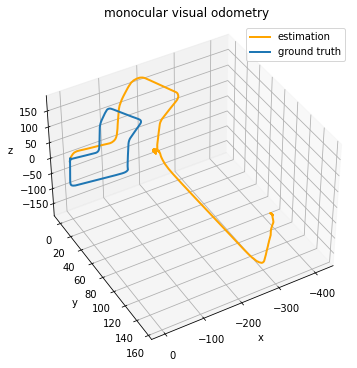

In [10]:
eval.plot('monocular visual odometry')

While this approach can still estimate camera trajectory, it is more susceptible to several issues compared to stereo-based methods. One major issue is **scale ambiguity**, as depth information cannot be directly inferred from a single image. This leads to an inability to recover absolute motion without additional constraints. Another critical problem is **drift**, where small errors in frame-to-frame motion estimation accumulate over time, causing significant deviations from the true trajectory. Factors such as feature tracking failures, occlusions, and varying lighting conditions further degrade accuracy.

### Visual Odometry with Stereo Depth Estimation

In this test, I use **Block Matching (BM)** as the stereo matcher, paired with the ORB detector and Brute Force feature matcher. Since a stereo matcher is specified, the system will apply stereo depth estimation to compute depth information, which will serve as a reference for motion estimation. The depth map is then used in conjunction with the `P3P` algorithm to estimate the camera's motion, providing a more accurate and reliable trajectory estimation by incorporating depth cues from the stereo images. This approach improves the system's robustness in dynamic environments by considering 3D spatial relationships between features.

In [11]:
%matplotlib inline
handler = DatasetHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    stereo_matcher='bm',
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2 = handler.next_frame()
    vo.update(image0, image1, image2)

100%|██████████| 1105/1105 [00:45<00:00, 24.40it/s]


In [12]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

MSE: 1221.7066, MAE: 34.9529, RMSE: 34.9529.


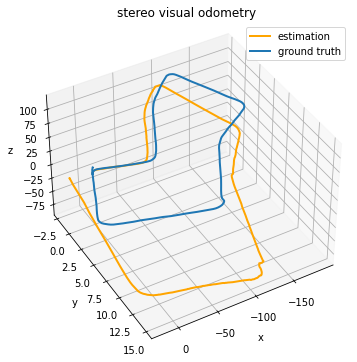

In [13]:
eval.plot('stereo visual odometry')

There is a noticeable improvement compared to the monocular approach. By incorporating stereo depth estimation, the system gains access to accurate depth information, which helps resolve scale ambiguities present in monocular visual odometry.

### Stereo Depth Estimation with LiDAR Correction

Stereo depth estimation with LiDAR correction is a technique that combines stereo vision and LiDAR data to improve the accuracy of depth estimation. In this approach, stereo vision is used to estimate the depth of the scene from two camera images, while LiDAR provides precise 3D point cloud data. The depth estimates from the stereo vision system are then corrected using the more accurate LiDAR data, refining the depth map and reducing errors caused by factors like occlusions, poor texture, or lighting conditions.

In [18]:
%matplotlib inline

handler = WLidarHandler()
vo = VisualOdometry(
    handler.K0,
    handler.K1,
    handler.Tr,
    handler.imsize,
    lidar=True,
    stereo_matcher='sgbm',
    detector='sift',
    matching_threshold=0.5
)

for _ in tqdm(range(handler.frame_num - 1)):
    image0, image1, image2, pcl = handler.next_frame()
    vo.update(image0, image1, image2, pcl)

100%|██████████| 1105/1105 [04:35<00:00,  4.01it/s]


In [19]:
eval = TrajectoryEvaluator(handler.gt, vo.traj)
eval.error()

MSE: 1131.4299, MAE: 33.6367, RMSE: 33.6367.


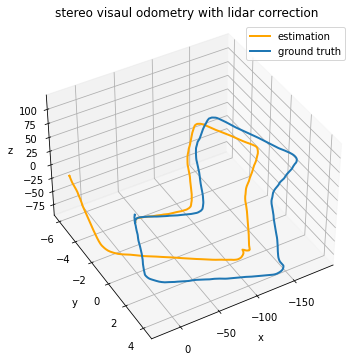

In [20]:
eval.plot('stereo visaul odometry with lidar correction')